**генеративно-состязательные модели (GAN)** 

Евгений Борисов borisov.e@solarl.ru

In [86]:
# пара нейросетей генератор (создаёт "подделку") и дискриминатор (распознаёт подделку)

# одна эпоха обучения состоит из следующих шагов

# 1. генератор создаёт пакет "подделок" из случайного шума

# 2. дискриминатор имеет пакет "настоящих" образцов 
#    и обучается распознавать фальшивки на наборе фальшивые/настоящие

# 3. собираем конвейер генератор-дискриминатор
#    фиксируем веса дискриминатора (т.е. дискриминатор в конвейере не обучаем)
#    и обучаем генератор "обманывать" дискриминатор

In [87]:
#  Gulli Antonio, Pal Sujit. Deep Learning with Keras -- Packt Publishing, 2017

In [88]:
import numpy as np
import IPython


In [89]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape

from tensorflow.keras.optimizers import SGD

from tensorflow.keras.datasets import mnist

from tensorflow.keras import backend as K

from tensorflow.keras.utils import plot_model

In [90]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
tf.__version__, tf.keras.__version__

('1.13.1', '2.2.4-tf')

---

In [91]:
# !rm -r result_old
# !mv result result_old
# !mkdir result

---

In [92]:
(X_train, _),(_, _) = mnist.load_data()

X_train.shape

(60000, 28, 28)

In [93]:
img_rows, img_cols = X_train.shape[1], X_train.shape[2]
img_rows, img_cols

(28, 28)

In [94]:
X_train = (X_train - 127.5) / 127.5

In [95]:
# X_train = X_train[:,np.newaxis,:,:].astype('float32')
X_train = X_train[:,:,:,np.newaxis].astype('float32')
X_train.shape

(60000, 28, 28, 1)

---

In [96]:
generator = Sequential(name='generator')
generator.add(Dense(1024, input_shape=(100, ), activation='tanh'))
generator.add(Dense(128 * 7 * 7))
generator.add(BatchNormalization())
generator.add(Activation('tanh'))
generator.add(Reshape((7, 7, 128), input_shape=(7 * 7 * 128,)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64,(5,5),padding='same',activation='tanh',data_format='channels_last'))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1,(5,5),padding='same',activation='tanh',data_format='channels_last'))

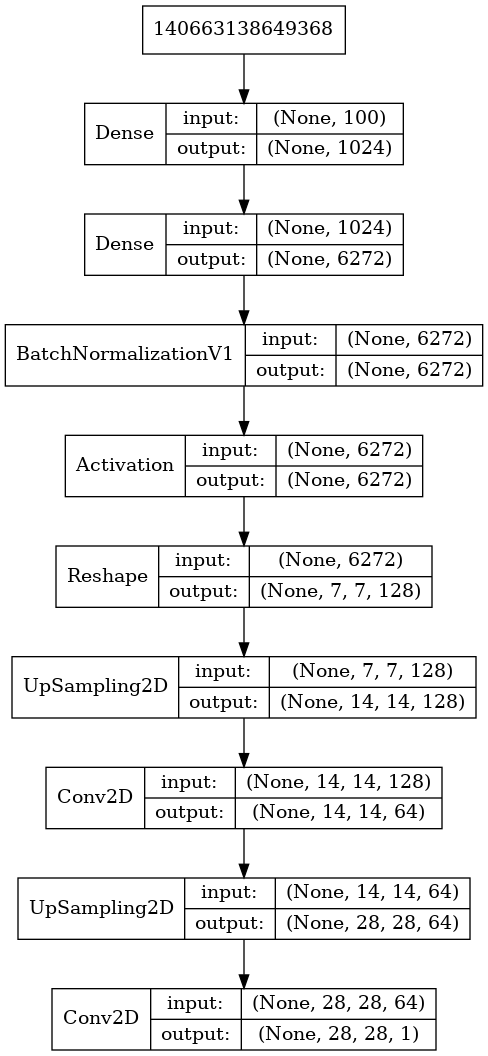

In [97]:
plot_model(generator,to_file='result/model-generator.png', show_layer_names=False, show_shapes=True )
IPython.display.Image('result/model-generator.png')

----

In [98]:
discriminator = Sequential(name='discriminator')
discriminator.add(Conv2D(64, (5, 5),
                padding='same',
                input_shape=(28, 28, 1),
                activation='tanh',
                data_format='channels_last'
   ))
discriminator.add(MaxPooling2D(pool_size=(2, 2)))
discriminator.add(Conv2D(128,(5,5),activation='tanh',data_format='channels_last'))
discriminator.add(MaxPooling2D(pool_size=(2, 2)))
discriminator.add(Flatten())
discriminator.add(Dense(1024, activation='tanh'))
discriminator.add(Dense(1, activation='sigmoid'))

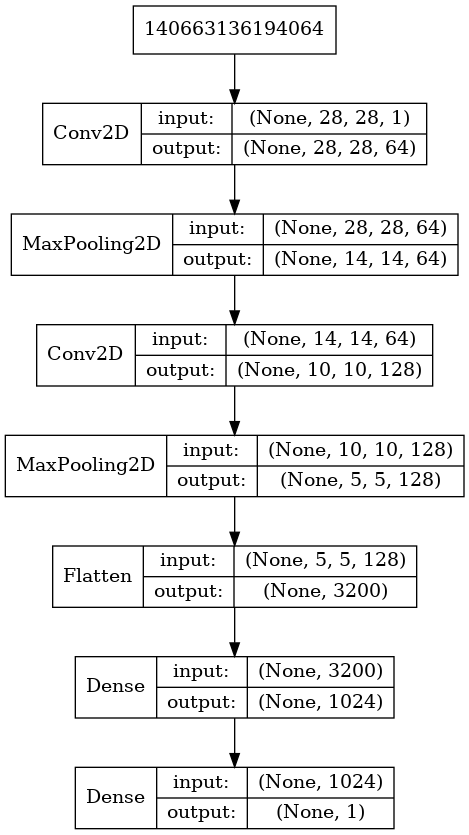

In [99]:
plot_model(discriminator,to_file='result/model-discriminator.png',show_layer_names=False, show_shapes=True )
IPython.display.Image('result/model-discriminator.png')

---

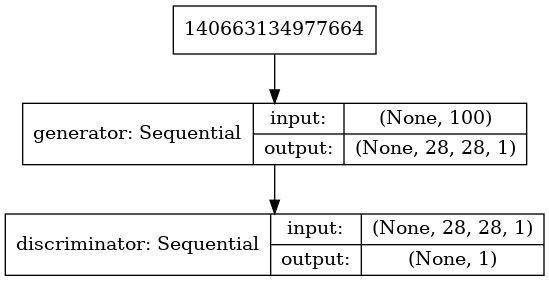

In [100]:
discriminator_on_generator = Sequential()
discriminator_on_generator.add(generator)
discriminator.trainable = False
discriminator_on_generator.add(discriminator)

plot_model( discriminator_on_generator, 
            to_file='result/model-discriminator_on_generator.png', 
            show_shapes=True, 
            show_layer_names=True )

IPython.display.Image('result/model-discriminator_on_generator.png')

---

In [101]:
generator.compile(loss='binary_crossentropy', optimizer="SGD")

discriminator_on_generator.compile(
    loss='binary_crossentropy', 
    optimizer=SGD(lr=0.0005, momentum=0.9, nesterov=True)
  )

discriminator.trainable = True
discriminator.compile(
    loss='binary_crossentropy', 
    optimizer=SGD(lr=0.0005, momentum=0.9, nesterov=True)
  )


---

In [102]:
from PIL import Image

def save_images(X,e,b,mc=10):
    # mc = 14 # количество картинок в одной строке 
    n,r,c,m = X.shape # примеры, высота, ширина, каналы
    mr = int(np.ceil(n/mc)) # количество строк 
    
    # print(n,c,r,m)
    
    im = []
    for k in range(m):
        xk = X[:,:,:,k] # канал k
        xk = np.vstack([xk,-np.ones([(mc*mr-n),r,c])]) # дополняем строку до полного размера картинки
        # укладываем картинки, [mr x mc] картинок размера [r x c]
        xk = xk.reshape(mr,mc,r,c).swapaxes(1,2).reshape(mr*r,mc*c) 
        im.append(xk*127.5+127.5) # масштабируем в [0,255]

    im = np.stack(im,axis=2) if m>1 else im[0]
   
    Image.fromarray(im.astype(np.uint8)).save('result/%02d_%d.png'%(e,b) )


In [103]:
# xx = np.random.rand(128,100,3)*255.
# Image.fromarray(xx.astype(np.uint8)).save('result/test.png')

---

In [104]:
BATCH_SIZE = 250
N_EPOCH = 50

N_EX = X_train.shape[0]
N_BATCH = int( np.floor(N_EX/BATCH_SIZE) )

mc=int(np.ceil(np.sqrt(BATCH_SIZE))) 

N_EX, N_BATCH

(60000, 240)

In [105]:
def chunks(X, batch_size=BATCH_SIZE): 
    for i in range(0, len(X), batch_size): 
        yield X[i:i+batch_size]

In [ ]:
%%time

for e in range(N_EPOCH):
    print('epoch: ', e+1,'/',N_EPOCH)
    
    for b,Xb in enumerate(chunks(X_train)):
        print('\tbatch %d/%d, loss '%(b+1,N_BATCH))

        # генератор создаёт пакет "подделок" из случайного шума
        noise = np.random.uniform(-1, 1, (BATCH_SIZE,100))
        Xg = generator.predict(noise, verbose=0)
        
        # рисуем результат после каждого 200-го батча
        if b % 200 == 0: save_images(Xg,e,b,mc=mc)
        
        # собираем учебный набор для дискриминатора
        # из "фальшивых" и "настоящик" картинок
        X = np.concatenate((Xb, Xg))
        y = [1] * Xb.shape[0] + [0] * Xg.shape[0]

        # обучаем дискриминатор выявлять "фальшивые"
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(X, y)
        print('\t\t%f : discriminator'%(d_loss))
        
        # обучаем генератор "обманывать" дискриминатор
        noise = np.random.uniform(-1,1,(BATCH_SIZE,100))
        discriminator.trainable = False
        g_loss = discriminator_on_generator.train_on_batch( noise, [1]*BATCH_SIZE)
        
        print('\t\t%f : generator'%(g_loss))


epoch:  1 / 50
	batch 1/240, loss 
		0.673911 : discriminator
		0.647327 : generator
	batch 2/240, loss 
		0.665087 : discriminator
		0.642106 : generator
	batch 3/240, loss 
		0.654217 : discriminator
		0.634115 : generator
	batch 4/240, loss 
		0.647392 : discriminator
		0.634131 : generator
	batch 5/240, loss 
		0.631787 : discriminator
		0.624106 : generator
	batch 6/240, loss 
		0.627159 : discriminator
		0.618648 : generator
	batch 7/240, loss 
		0.603019 : discriminator
		0.611929 : generator
	batch 8/240, loss 
		0.593812 : discriminator
		0.604503 : generator
	batch 9/240, loss 
		0.582609 : discriminator
		0.597556 : generator
	batch 10/240, loss 
		0.560429 : discriminator
		0.593754 : generator
	batch 11/240, loss 
		0.551003 : discriminator
		0.586477 : generator
	batch 12/240, loss 
		0.540060 : discriminator
		0.578206 : generator
	batch 13/240, loss 
		0.520906 : discriminator
		0.571714 : generator
	batch 14/240, loss 
		0.510235 : discriminator
		0.566665 : generator


		0.257302 : discriminator
		0.940101 : generator
	batch 117/240, loss 
		0.266742 : discriminator
		0.925725 : generator
	batch 118/240, loss 
		0.232756 : discriminator
		0.923144 : generator
	batch 119/240, loss 
		0.252170 : discriminator
		0.905408 : generator
	batch 120/240, loss 
		0.270791 : discriminator
		0.920439 : generator
	batch 121/240, loss 
		0.254001 : discriminator
		0.898950 : generator
	batch 122/240, loss 
		0.246353 : discriminator
		0.921010 : generator
	batch 123/240, loss 
		0.263568 : discriminator
		0.882395 : generator
	batch 124/240, loss 
		0.238244 : discriminator
		0.881245 : generator
	batch 125/240, loss 
		0.264568 : discriminator
		0.880180 : generator
	batch 126/240, loss 
		0.249053 : discriminator
		0.858485 : generator
	batch 127/240, loss 
		0.271143 : discriminator
		0.869627 : generator
	batch 128/240, loss 
		0.255245 : discriminator
		0.860696 : generator
	batch 129/240, loss 
		0.232749 : discriminator
		0.850952 : generator
	batch 130/240

In [ ]:
generator.save_weights('result/generator', True)
discriminator.save_weights('result/discriminator', True)

---

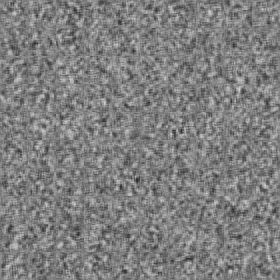

In [23]:
# вход (начальное состояние)
IPython.display.Image('result/00_0.png')

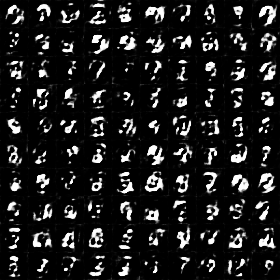

In [24]:
# после 1 эпохи обучения
IPython.display.Image('result/02_0.png')

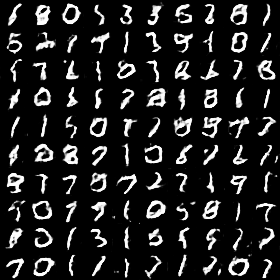

In [25]:
# после 9 эпохи обучения
IPython.display.Image('result/09_0.png')

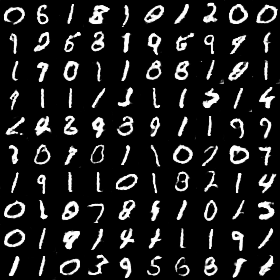

In [26]:
# конечный результат (50 эпох обучения)
IPython.display.Image('result/49_400.png')